<small><i>(c) October 2016 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol).</i></small>

# pill 9 - Combating overfitting

<div class = "alert alert-danger">**CODE DEPENDENCY:**  `cvxpy`</div>

In MAC Sierra it may fail compilation:

solution: run in a terminal `xcode-select --install` to install command line tools

Outline:

+ Introduction to regularization
+ Early stopping 
+ Norm regularizers
+ Data augmentation and dropout


# The toy problem

Let us take our well known toy problem 

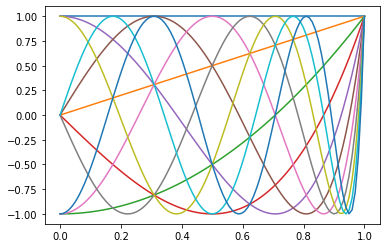

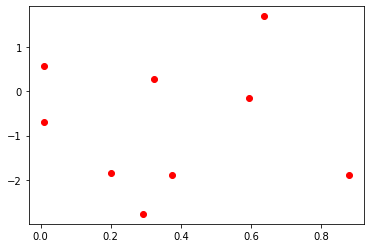

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def polyval(coefs, x):
    res = coefs[0]*np.ones((1,x.shape[0]))
    for i in range(1,len(coefs)):
        res = res + coefs[i]*np.power(x,i)
    return res
        

def chebys (coefs, x):
    pol = {}
    pol[0] = [1][::-1]
    pol[1] = [1, 0][::-1]
    pol[2] = [2, 0, -1][::-1]
    pol[3] = [4, 0, -3, 0][::-1]
    pol[4] = [8, 0, -8, 0, 1][::-1]
    pol[5] = [16, 0, -20, 0, 5, 0][::-1]
    pol[6] = [32, 0, -48, 0, 18, 0, -1][::-1]
    pol[7] = [64, 0, -112, 0, 56, 0, -7, 0][::-1]
    pol[8] = [128, 0, -256, 0, 160, 0, -32, 0, 1][::-1]
    pol[9] = [256, 0, -576, 0, 432, 0, -120, 0, 9, 0][::-1]
    pol[10] = [512, 0, -1280, 0, 1120, 0, -400, 0, 50, 0, -1][::-1]
    pol[11] = [1024, 0, -2816, 0, 2816, 0, -1232, 0, 220, 0, -11, 0][::-1]

    res = np.zeros((1,x.shape[0]))

    for i in range(len(coefs)):
        res= res + coefs[i]*polyval(pol[i],x)
    return res

        
x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt

for i in range(11):
    co = np.zeros((11,))
    co[i]=1.
    plt.plot(x,chebys(co,x).ravel())
    
#Create a polynomial with noise
np.random.seed(42)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

vals=chebys(coefs,x).ravel()
#plt.plot(x,vals)

N=9
idx = np.random.randint(0,100,N)
data = vals[idx]+1.*np.random.normal(size=len(idx))
plt.figure()
plt.plot(x[idx],data,'ro')

x_train = x[idx][:,np.newaxis]
y_train = data[:,np.newaxis]

In [2]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

(-10.0, 10.0)

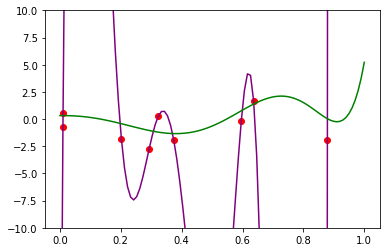

In [3]:
w_analytic = np.dot(np.linalg.pinv(np.dot(X,X.T)),np.dot(X,y_train))
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w_analytic)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

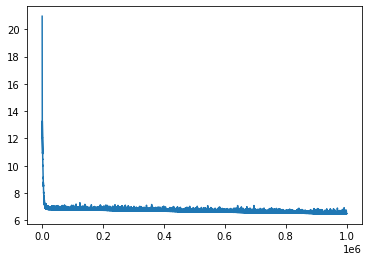

In [4]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    conv.append(J)
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

(-10.0, 10.0)

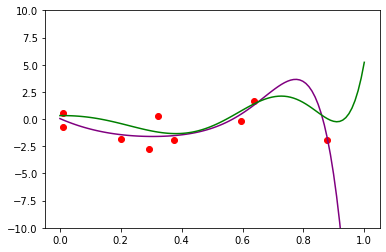

In [6]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])


In [6]:
print (np.abs(np.sum(w.T-w_analytic.T)))

18570.32459373196


# Early stoping 

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `n_iters` to $100000$, $10000$, $1000$, $100$, and $10$. Create a plot with the in-sample and the out-of-sample values for the former problem. What is the effect of not letting the method converge?
</div>

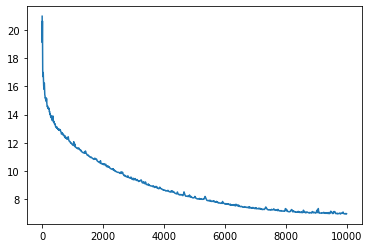

In [7]:
#your code here
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 10000
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999

for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    conv.append(J)
    
plt.plot(conv)

(-10.0, 10.0)

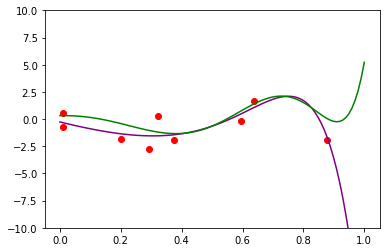

In [8]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

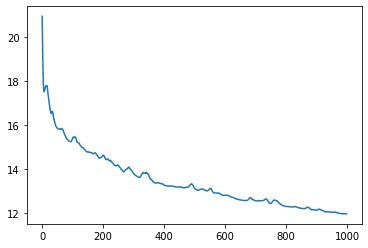

In [9]:
#your code here
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999

for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    conv.append(J)
    
plt.plot(conv)

(-10.0, 10.0)

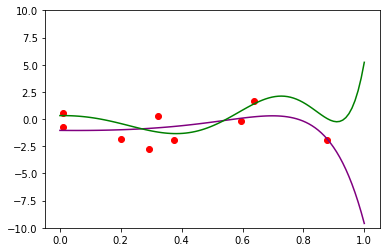

In [10]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

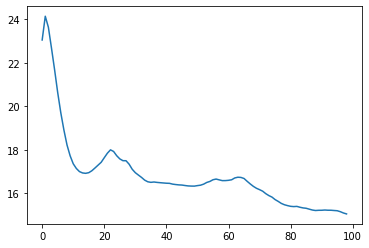

In [11]:
#your code here
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 100
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999

for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    conv.append(J)
    
plt.plot(conv)

(-10.0, 10.0)

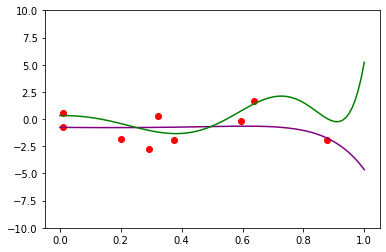

In [12]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

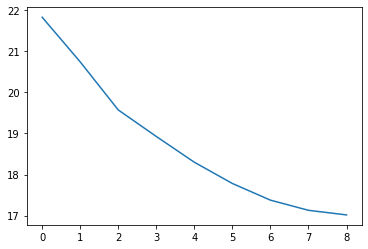

In [13]:
#your code here
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 10
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999

for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    conv.append(J)
    
plt.plot(conv)

(-10.0, 10.0)

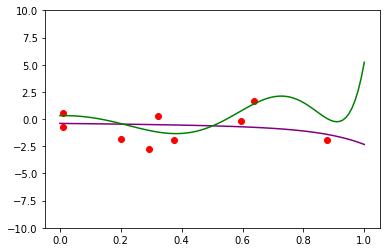

In [14]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

# Combating overfitting

The reasoning on how to cure overfitting comes from the very well known bound
$$E_{out}\leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

We want to control the out-of-sample error, thus we have a couple of routes to take:

1. Either we simulate the out-of-sample error and check against unseen data. This is working directly with the left hand side of the inequality. We can do this using **cross-validation**.
2. We change the learning objective to take into account and minimize the complexity of the model. We mimick the right hand side of the inequality and add to the objective function a term penalizing complexity. This is called **regularization**.

3. We can use **ensemble techniques**. Implicitly this strategy is similar to the complexity control technique.

# Regularization

Regularization tries to explicitly model the complexity of the model. In simple words, you give information to the optimization process telling what model you prefer in the absence of data (we can see this as a kind of bias).



## Combating overfitting with norms: A matter of balls

The definition of complexity of a model is ambiguous. Does it mean that it depends on a few elements of a basis? Is it related to the smoothness of the solution? The norm of a vector 

>In linear algebra, functional analysis, and related areas of mathematics, a norm is a function that assigns a strictly positive length or size to each vector in a vector space—save for the zero vector, which is assigned a length of zero. - *Wikipedia*

A very well known norm to use is $\ell_p$ norm, defined as

$$\|\alpha\|_p = \big(\sum_i |\alpha_i|^p\big)^{1/p}$$

Let us have a look at some of them,

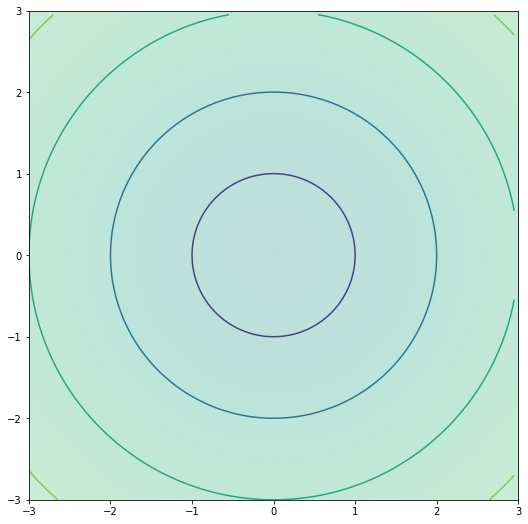

In [15]:
#order = np.Inf
order = 2
delta = 0.05
xx = np.arange(-3.0, 3.0, delta)
yy = np.arange(-3.0, 3.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = np.linalg.norm(data,ord = order,axis = 1)
Z.shape=sz
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-3,3,-3,3),alpha=0.3, vmin=-10, vmax=10)
plt.contour(XX,YY,Z,[0,1,2,3,4,5])
fig = plt.gcf()
fig.set_size_inches(9,9)

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `order` to $0.5$, $1$, and `np.Inf`. Consider that we add a norm of the desired order to the linear regression problem. What is the expected effect of each of the norms?</div>

<div class = "alert alert-info" style = "border-radius:10px"> **ABOUT $\ell_1$ and $\ell_2$: **Observe that when we move over the norm isosurface this tells us what happends when one increases the value of one parameter to the value of the rest. For example in $\ell_2$ norms if you increase the value of one parameter you decrease the value of the other by a little. How much? 
<p>
Consider the point ${\bf x} = (x_1,x_2)$ with $\|x\|_2 = 1$. Let us perturbe one of the elements and find out what happens to the other so that the norm is constant, ${\bf x'} = (x_1+\epsilon,x_2+\delta)$ with norm $\|x'\|_2 = x_1^2+\epsilon^2+2x_1\epsilon + x_2^2 + \delta^2 + 2x_2\delta = 1$. Observe that because $\|x\|_2 = 1$ we have that $\delta^2 + 2x_2\delta +\epsilon^2+2x_1\epsilon = 0$ with solutions 

$$\delta = -2x_2\pm \sqrt{4 x_2 - 4 (\epsilon^2+2x_1\epsilon)}$$

If $\|x\|_1 = 1$, then $\|x'\|_1 = |x_1| + |x_2| + \epsilon + \delta = 1$ and we see that it is equivalent to $\delta = -\epsilon$. This is, when I increase one of them I reduce the other by the same quantity. This means that if we need some values to be large we have to reduce others by the same quantity. Thus it is probable we find values equal to zero. 
</p>
<p>
Consider the classic pictures showing the norm level sets and a quadratic function objective. Consider now that we want to optimize that quadratic function with the constraint $\|x\|=C$.  Suppose that the relative location of the minimum with respect to the constraint has an optimum value such that it lies on one of the axis. This is, the solution is zero for that component of the optimization variable. If the constraining norm corresponds to an $\ell_2$ norm, if we move the objective problem a little we can easily see that only by following the minimum level set of the objective we can have that coordinate of the solution to still be zero. Any other solution will intercept the norm ball always outside the zero value. 
</p>
<p>
If the constraint is an $\ell_1$, following the same level set as in the former case we have a similiar conclusion. However, moving the solution outside that trajectory we find many other problems that have that same minimizer (with the coordinate being equal to zero). Thus, we may conclude that by using $\ell_1$, it is more probable that we find solutions with components equal to zero. In practice, this constraint impose sparsity on the solution.
</p>

</div>

Let us check the effect of adding a norm to the problem. Remember that by adding the norm we are trying to simulate the right hand side of equation 

$$E_{out} \leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

where the norm is a potential measure of the complexity of the model.

In that case, the optimization problem becomes

$$
\begin{align}
\text{minimize } & \quad (f_0(x), \|x\|_p)\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

where $x$ is the variable we are optimizing (not to be confused with the data when applying to the machine learning case). Adding a new term to optimize with repect to, converts the problem into a multiple optimization problem. This usually means that there is not a unique solution since usually the different functions to be optimized compete. The surface of all solutions is called *Pareto's optimal surface*. One way to travel along the Pareto's surface is to use a method called scalarization. This consists of making a weighted combination of both functions

$$
\begin{align}
\text{minimize } & \quad f_0(x) + \lambda \|x\|_p\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

Let us solve the problem of least squares with different norms and see what happens.

We will use CVXPY, a disciplined convex optimization module that allows to solve convex optimization problems. Find in the following lines an example.

In [16]:
import cvxpy as cp
import numpy



d = X.shape[0]
N = X.shape[1]

# Construct the problem.
w = cp.Variable((d,1))
error = cp.sum_squares(X.T@w - y_train)
constraint = [cp.norm(w,2)<=10000]
obj = cp.Minimize(error)
prob = cp.Problem(obj,constraint)
prob.solve()


5.357336172146505

In [17]:
prob.status

'optimal'

In [18]:
print ('Near zero values: ' + str(len(np.where(np.abs(w.value)<1e-6)[0])))

print (w.value)

Near zero values: 0
[[-1.65785927e-01]
 [ 1.46906063e+01]
 [-4.58970869e+02]
 [ 2.72156617e+03]
 [-5.74652700e+03]
 [ 2.36328867e+03]
 [ 4.47516188e+03]
 [-2.68588847e+02]
 [-3.95755103e+03]
 [-2.54663852e+03]
 [ 3.39524659e+03]]


(-10.0, 10.0)

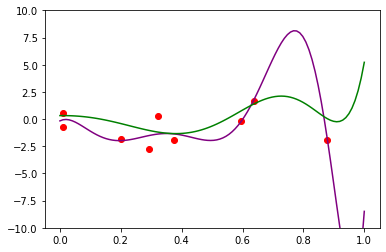

In [19]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Modify the code to accomodate $\ell_p$ norm regularization. Observe the values of the weights in the different configuration of the norms. Describe them. (Check the `Norm` function)</div>

In [ ]:
#your code

(-10.0, 10.0)

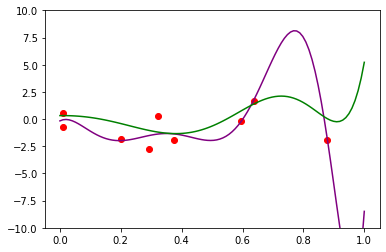

In [20]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

# Using stochastic subgradient methods

Let us modify our stochastic subgradient method to achieve the same performance.

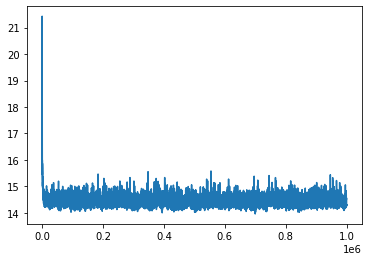

In [15]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=3
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.1
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

In [16]:
wopt

array([[-0.88307675],
       [-0.01554622],
       [ 1.9553521 ],
       [ 0.00965277],
       [-0.0058745 ],
       [-0.01588849],
       [-0.0656605 ],
       [-0.3279081 ],
       [-4.7816785 ],
       [-0.43122588],
       [-0.13499459]])

(-10.0, 10.0)

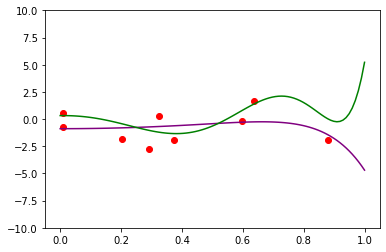

In [17]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])

# Data augmentation and the dropout technique

The goal of regularization is to avoid overfitting. We have seen that one way of avoiding overfitting is not to let the method overfit. Overfitting occurs when the relationship between the complexity of the method and the number of available samples is large. This is, the model is too much complex for the amount of data. One way of delaying overfitting is to artificially create new data. This is called **data augmentation**. 



<div class = "alert alert-success" style = "border-radius:10px"> **EXERCISE: ** Discuss with your partner posible ways for augmenting data.</div>

We may estimate the probability density function and then sample from that. Or use interpolation methods. Another technique is to add noise to the current data while perserving the label from the original data. This is the basic idea behind the **dropout** technique. In this technique one cancels the value of the attributes at random when training. This is esentially the same as adding "salt and pepper" noise.

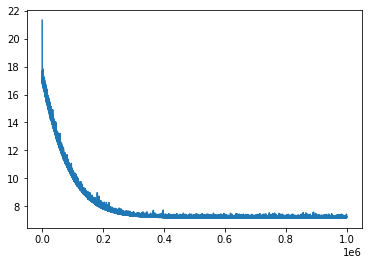

In [18]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = w
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.00
prc = 0.00
for k in range(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    x_sample = X[:,i]
    y_sample = y_train[i,:]

    
    ## DROPOUT
    #n = np.random.rand(X.shape[0],X.shape[1])<prc
    #x_sample[n] = 0.
    
    ## NOISY AUGMENTATION
    x_sample =  x_sample + 1. *np.random.normal()
        
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

(-10.0, 10.0)

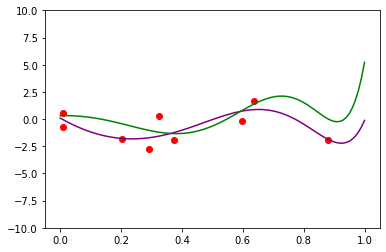

In [19]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'purple')
plt.plot(x,vals,'green')
plt.gca().set_ylim([-10,10])